In [1]:
from IPython.display import HTML
import random

# Standard data science libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.close('all')
sns.set(color_codes=True)
matplotlib.rc("font", size=20)
matplotlib.rc("xtick", labelsize=20)
matplotlib.rc("ytick", labelsize=20)
matplotlib.rc("axes", labelsize=24)
matplotlib.rc("axes", titlesize=28)
matplotlib.rc("legend", fontsize=14)
matplotlib.rc("figure", titlesize=24)

## If in IPython, load autoreload
if 'ipython' in globals():
  print("Welcome to IPython!")
  ipython.magic('load_ext autoreload')
  ipython.magic('autoreload 2')
  ipython.magic('matplotlib inline')
else:
  %matplotlib inline

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

print("Numpy, Matplotlib, and Seaborn have been loaded!")


def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code
                          # in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

hide_toggle()


Numpy, Matplotlib, and Seaborn have been loaded!


In [76]:
import anndata as ad
import h5py
import scanpy as sc
from scipy.io import mmread
import scipy.sparse as sp
from tss_enrichment_utility import *

In [3]:
def read_h5(filename, omic='ATAC'):
    """\
    Read `.h5` (hdf5) file.
    
    This function was taken from the epiScanpy repo: https://github.com/colomemaria/epiScanpy
    
    Parameters
    ----------
    filename
        Filename of data file.
    omic
        Type of single cell data present in the data file
    """
    # open the file
    f = h5py.File(filename, 'r')
    
    #extract obs and var
    barcodes = [x.decode('UTF-8') for x in f['matrix']['barcodes']]
    var = pd.DataFrame()
    if "id" in list(f['matrix']['features'].keys()):
        var["id"] = [x.decode('UTF-8') for x in f['matrix']['features']["id"]]
        var.index = var["id"]
    if "name" in list(f['matrix']['features'].keys()):
        var["name"] = [x.decode('UTF-8') for x in f['matrix']['features']["name"]]
    del var["id"]
    
    
    # extract and re-construct the csr_matrix
    keys = [k for k in f['matrix'].keys()]
    X = f['matrix']["data"][()]
    # try to find row and column names
    rows_cols = [{}, {}]
    for iname, name in enumerate(["indptr", "indices"]):
        if name in keys:
            rows_cols[iname][name] = f['matrix'][name][()]
    
    X = sp.csr_matrix((X, rows_cols[1]["indices"], rows_cols[0]["indptr"]))
    adata = ad.AnnData(X, obs=pd.DataFrame(index=barcodes), var=var)
    adata.uns['omic'] = omic
    return(adata)

In [4]:
adata = read_h5("../data/10xGenomics_ATACseq/atac_pbmc_10k_nextgem_filtered_peak_bc_matrix.h5")

In [6]:
from tss_enrichment_utility import *
tss_enrichment(adata, 
               fragments="../data/10xGenomics_ATACseq/atac_pbmc_10k_nextgem_fragments.tsv.gz",
               gtf="../data/10xGenomics_ATACseq/gencode.v38.annotation.gtf.gz",
               n_jobs=-1)

adata_2 = adata.copy()

[W::hts_idx_load3] The index file is older than the data file: ../data/10xGenomics_ATACseq/atac_pbmc_10k_nextgem_fragments.tsv.gz.tbi
[W::hts_idx_load3] The index file is older than the data file: ../data/10xGenomics_ATACseq/atac_pbmc_10k_nextgem_fragments.tsv.gz.tbi
[W::hts_idx_load3] The index file is older than the data file: ../data/10xGenomics_ATACseq/atac_pbmc_10k_nextgem_fragments.tsv.gz.tbi
[W::hts_idx_load3] The index file is older than the data file: ../data/10xGenomics_ATACseq/atac_pbmc_10k_nextgem_fragments.tsv.gz.tbi
[W::hts_idx_load3] The index file is older than the data file: ../data/10xGenomics_ATACseq/atac_pbmc_10k_nextgem_fragments.tsv.gz.tbi
[W::hts_idx_load3] The index file is older than the data file: ../data/10xGenomics_ATACseq/atac_pbmc_10k_nextgem_fragments.tsv.gz.tbi
[W::hts_idx_load3] The index file is older than the data file: ../data/10xGenomics_ATACseq/atac_pbmc_10k_nextgem_fragments.tsv.gz.tbi
[W::hts_idx_load3] The index file is older than the data file:

It's working!
It's working!
It's working!
It's working!
It's working!
It's working!
It's working!
It's working!


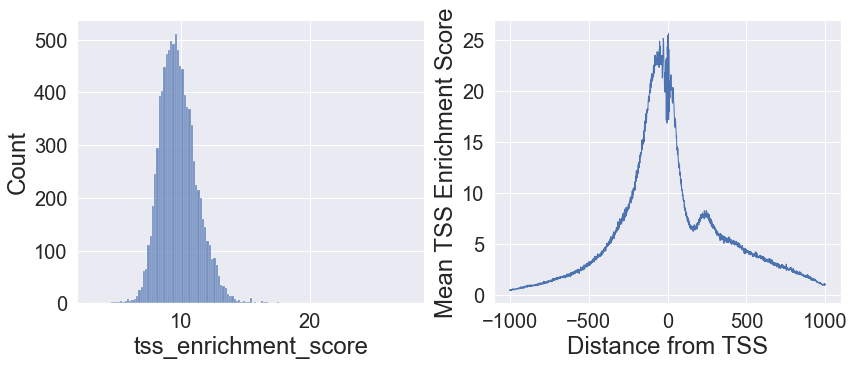

In [7]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 5))

_ = sns.histplot(adata.obs.tss_enrichment_score, ax=ax1)

_ = ax2.plot(adata.uns['tss_enrichment']['x'],
             adata.uns['tss_enrichment']['mean_fold_change'],
             lw=1, color='C0')

_ = ax2.set_xlabel("Distance from TSS")
_ = ax2.set_ylabel("Mean TSS Enrichment Score")

_ = fig.tight_layout()

In [8]:
metadata = pd.read_csv("../data/10xGenomics_ATACseq/atac_v1_pbmc_10k_peak_annotation.tsv", index_col=None, header=0, delimiter='\t')
metadata

,peak,gene,distance,peak_type
0,chr1_565113_565543,OR4F16,56510,distal
1,chr1_569179_569635,OR4F16,52418,distal
2,chr1_713534_714806,AL669831.1,24331,distal
3,chr1_752436_753020,AL669831.1,-13300,distal
4,chr1_762144_763353,AL669831.1,-23008,distal
...,...,...,...,...
80229,chrY_23418918_23419001,PRORY,129245,distal
80230,chrY_23422186_23422618,PRORY,125628,distal
80231,chrY_23584049_23584422,PRORY,-35804,distal
80232,chrY_28816422_28818023,NaN,NaN,intergenic


In [47]:
adata_2 = adata.copy()
adata_2.var

,name
id,
chr1:9781-10672,chr1:9781-10672
chr1:180678-181311,chr1:180678-181311
chr1:184004-184867,chr1:184004-184867
chr1:186550-187463,chr1:186550-187463
chr1:191198-192095,chr1:191198-192095
...,...
KI270713.1:21358-22260,KI270713.1:21358-22260
KI270713.1:25966-26842,KI270713.1:25966-26842
KI270713.1:29713-30529,KI270713.1:29713-30529


In [45]:
adata_2.var = adata_2.var.reset_index()
adata_2.var = adata_2.var.rename(columns={"id": "peak"})
adata_2.var

,peak,name
0,chr1:9781-10672,chr1:9781-10672
1,chr1:180678-181311,chr1:180678-181311
2,chr1:184004-184867,chr1:184004-184867
3,chr1:186550-187463,chr1:186550-187463
4,chr1:191198-192095,chr1:191198-192095
...,...,...
144018,KI270713.1:21358-22260,KI270713.1:21358-22260
144019,KI270713.1:25966-26842,KI270713.1:25966-26842
144020,KI270713.1:29713-30529,KI270713.1:29713-30529
144021,KI270713.1:34051-35030,KI270713.1:34051-35030


In [41]:

adata_2.var.merge(metadata, how='left', on='peak')

,peak,name,gene,distance,peak_type
0,chr1:9781-10672,chr1:9781-10672,NaN,NaN,NaN
1,chr1:180678-181311,chr1:180678-181311,NaN,NaN,NaN
2,chr1:184004-184867,chr1:184004-184867,NaN,NaN,NaN
3,chr1:186550-187463,chr1:186550-187463,NaN,NaN,NaN
4,chr1:191198-192095,chr1:191198-192095,NaN,NaN,NaN
...,...,...,...,...,...
144018,KI270713.1:21358-22260,KI270713.1:21358-22260,NaN,NaN,NaN
144019,KI270713.1:25966-26842,KI270713.1:25966-26842,NaN,NaN,NaN
144020,KI270713.1:29713-30529,KI270713.1:29713-30529,NaN,NaN,NaN
144021,KI270713.1:34051-35030,KI270713.1:34051-35030,NaN,NaN,NaN


In [77]:
find_genes(adata,
           gtf_file='../data/10xGenomics_ATACseq/gencode.v38.annotation.gtf',
           key_added='transcript_annotation',
           upstream=2000,
           feature_type='transcript',
           annotation='HAVANA',
           raw=False)

In [ ]:
gtf = {}
    with open(gtf_file) as f:
        for line in f:
            if line[0:2] != '##' and '\t'+feature_type+'\t' in line and '\t'+annotation+'\t' in line:
                line = line.rstrip('\n').split('\t')
                if line[6] == '-':
                    if line[0] not in gtf.keys():
                        gtf[line[0]] = [[int(line[3])-downstream, int(line[4])+upstream,line[-1].split(';')[:-1]]]
                    else:
                        gtf[line[0]].append([int(line[3])-downstream, int(line[4])+upstream,line[-1].split(';')[:-1]])
                else:
                    if line[0] not in gtf.keys():
                        gtf[line[0]] = [[int(line[3])-upstream, int(line[4])+downstream,line[-1].split(';')[:-1]]]
                    else:
                        gtf[line[0]].append([int(line[3])-upstream, int(line[4])+downstream,line[-1].split(';')[:-1]])
                        
                           # extracting the feature coordinates
    raw_adata_features = {}
    feature_index = 0
    for line in adata.var_names.tolist():
        line = line.split('_')
        if line[0] not in raw_adata_features.keys():
            raw_adata_features[line[0]] = [[int(line[1]),int(line[2]), feature_index]]
        else:
            raw_adata_features[line[0]].append([int(line[1]),int(line[2]), feature_index])
        feature_index += 1
        
    ## find the genes overlaping the features.
    gene_index = []
    for chrom in raw_adata_features.keys():
        if chrom in gtf.keys():
            chrom_index = 0
            previous_features_index = 0
            for feature in raw_adata_features[chrom]:
                gene_name = []
                feature_start = feature[0]
                feature_end = feature[1]
                for gene in gtf[chrom]:
                    if (gene[1]<= feature_start): # the gene is before the feature. we need to test the next gene.
                        continue
                    elif (feature_end <= gene[0]): # the gene is after the feature. we need to test the next feature.
                        break
                    else: # the window is overlapping the gene.
                        for n in gene[-1]:
                            if 'gene_name' in n:
                                gene_name.append(n.lstrip('gene_name "').rstrip('""'))

                if gene_name == []:
                    gene_index.append('intergenic')
                elif len(gene_name)==1:
                    gene_index.append(gene_name[0])
                else:
                    gene_index.append(";".join(list(set(gene_name))))

        else:
            for feature in raw_adata_features[chrom]:
                gene_index.append("unassigned")

    adata.var[key_added] = gene_index

In [79]:
gtf_column_names = ['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'attribute', 'other']

gtf = pd.read_csv("../data/10xGenomics_ATACseq/gencode.v38.annotation.gtf.gz",
    sep='\t',
    names=gtf_column_names,
    comment="#",
    header=None,
    index_col=False)

In [ ]:
gtf_other_cols = []
for gtf_other in gtf.other:
    gtf_other = [gtfo.strip() for gtfo in gtf_other.split(";")[:-1]]
    gtf_other_cols.append({gtfo.split(" ")[0].strip(): gtfo.split(" ")[1].strip() for gtfo in gtf_other})
print(gtf_other_cols)

In [ ]:
gtf_other_df = pd.from_records(gtf_other_cols)

In [63]:
HAVANA_gene_df = gtf[(gtf.feature == 'gene') & (gtf.source == 'HAVANA')]
HAVANA_gene_df

,seqname,source,feature,start,end,score,strand,attribute,other
0,chr1,HAVANA,gene,11869,14409,.,+,.,"gene_id ""ENSG00000223972.5""; gene_type ""transc..."
12,chr1,HAVANA,gene,14404,29570,.,-,.,"gene_id ""ENSG00000227232.5""; gene_type ""unproc..."
28,chr1,HAVANA,gene,29554,31109,.,+,.,"gene_id ""ENSG00000243485.5""; gene_type ""lncRNA..."
39,chr1,HAVANA,gene,34554,36081,.,-,.,"gene_id ""ENSG00000237613.2""; gene_type ""lncRNA..."
47,chr1,HAVANA,gene,52473,53312,.,+,.,"gene_id ""ENSG00000268020.3""; gene_type ""unproc..."
...,...,...,...,...,...,...,...,...,...
3150109,chrY,HAVANA,gene,57184101,57197337,.,+,.,"gene_id ""ENSG00000124334.17_PAR_Y""; gene_type ..."
3150164,chrY,HAVANA,gene,57190738,57208756,.,+,.,"gene_id ""ENSG00000270726.6_PAR_Y""; gene_type ""..."
3150170,chrY,HAVANA,gene,57201143,57203357,.,-,.,"gene_id ""ENSG00000185203.12_PAR_Y""; gene_type ..."
3150174,chrY,HAVANA,gene,57207346,57212230,.,+,.,"gene_id ""ENSG00000182484.15_PAR_Y""; gene_type ..."


In [69]:
upstream, downstream = 2000, 0

for seqname in HAVANA_gene_df.seqname.unique():
    subset_df = HAVANA_gene_df[HAVANA_gene_df.seqname == seqname]
    subset_df['left'] = np.where(subset_df.strand == '-', subset_df['start'] - downstream, subset_df['start'] - upstream)
    subset_df['right'] = np.where(subset_df.strand == '-', subset_df['start'] + upstream, subset_df['start'] + downstream)
subset_df

/var/folders/_v/n82vwlfd3wg7_t3361n20xhr0000gn/T/ipykernel_80505/2931172980.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df['left'] = np.where(subset_df.strand == '-', subset_df['start'] - downstream, subset_df['start'] - upstream)
/var/folders/_v/n82vwlfd3wg7_t3361n20xhr0000gn/T/ipykernel_80505/2931172980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df['right'] = np.where(subset_df.strand == '-', subset_df['start'] + upstream, subset_df['start'] + downstream)


,seqname,source,feature,start,end,score,strand,attribute,other,left,right
3140301,chrY,HAVANA,gene,253743,255091,.,+,.,"gene_id ""ENSG00000228572.7_PAR_Y""; gene_type ""...",251743,253743
3140305,chrY,HAVANA,gene,276322,303356,.,+,.,"gene_id ""ENSG00000182378.15_PAR_Y""; gene_type ...",274322,276322
3140431,chrY,HAVANA,gene,304529,318819,.,-,.,"gene_id ""ENSG00000178605.13_PAR_Y""; gene_type ...",304529,306529
3140462,chrY,HAVANA,gene,320990,321851,.,+,.,"gene_id ""ENSG00000226179.6_PAR_Y""; gene_type ""...",318990,320990
3140466,chrY,HAVANA,gene,333933,386955,.,-,.,"gene_id ""ENSG00000167393.18_PAR_Y""; gene_type ...",333933,335933
...,...,...,...,...,...,...,...,...,...,...,...
3150109,chrY,HAVANA,gene,57184101,57197337,.,+,.,"gene_id ""ENSG00000124334.17_PAR_Y""; gene_type ...",57182101,57184101
3150164,chrY,HAVANA,gene,57190738,57208756,.,+,.,"gene_id ""ENSG00000270726.6_PAR_Y""; gene_type ""...",57188738,57190738
3150170,chrY,HAVANA,gene,57201143,57203357,.,-,.,"gene_id ""ENSG00000185203.12_PAR_Y""; gene_type ...",57201143,57203143
3150174,chrY,HAVANA,gene,57207346,57212230,.,+,.,"gene_id ""ENSG00000182484.15_PAR_Y""; gene_type ...",57205346,57207346


In [75]:
adata.var['chromosome'] = [name.split(':')[0] for name in adata.var.name]
adata.var['start'] = [name.split(":")[1].split("-")[0] for name in adata.var.name]
adata.var['stop'] = [name.split(":")[1].split("-")[1] for name in adata.var.name]
adata.var

,name,chromosome,start,stop
id,,,,
chr1:9781-10672,chr1:9781-10672,chr1,9781,10672
chr1:180678-181311,chr1:180678-181311,chr1,180678,181311
chr1:184004-184867,chr1:184004-184867,chr1,184004,184867
chr1:186550-187463,chr1:186550-187463,chr1,186550,187463
chr1:191198-192095,chr1:191198-192095,chr1,191198,192095
...,...,...,...,...
KI270713.1:21358-22260,KI270713.1:21358-22260,KI270713.1,21358,22260
KI270713.1:25966-26842,KI270713.1:25966-26842,KI270713.1,25966,26842
KI270713.1:29713-30529,KI270713.1:29713-30529,KI270713.1,29713,30529


In [78]:
adata.var

,name,chromosome,start,stop,transcript_annotation
id,,,,,
chr1:9781-10672,chr1:9781-10672,chr1,9781,10672,DDX11L1
chr1:180678-181311,chr1:180678-181311,chr1,180678,181311,DDX11L17
chr1:184004-184867,chr1:184004-184867,chr1,184004,184867,DDX11L17
chr1:186550-187463,chr1:186550-187463,chr1,186550,187463,WASH9P
chr1:191198-192095,chr1:191198-192095,chr1,191198,192095,WASH9P
...,...,...,...,...,...
KI270713.1:21358-22260,KI270713.1:21358-22260,KI270713.1,21358,22260,unassigned
KI270713.1:25966-26842,KI270713.1:25966-26842,KI270713.1,25966,26842,unassigned
KI270713.1:29713-30529,KI270713.1:29713-30529,KI270713.1,29713,30529,unassigned
